# **Setting & Introduction**

## **1. Github 연동**

In [ ]:
""" github 연동 """
!git clone https://github.com/ku-sungsukim/2025-LGElec-Day11.git ### colab 사용시

Cloning into '2025-LGElec-Day11'...
remote: Enumerating objects: 817, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 817 (delta 9), reused 0 (delta 0), pack-reused 794 (from 2)
Receiving objects: 100% (817/817), 103.38 MiB | 10.63 MiB/s, done.
Resolving deltas: 100% (13/13), done.
Updating files: 100% (762/762), done.


In [ ]:
""" GPU 가능여부 확인 """
import torch
torch.cuda.is_available()

True

## **2. About Jupyter Notebook**

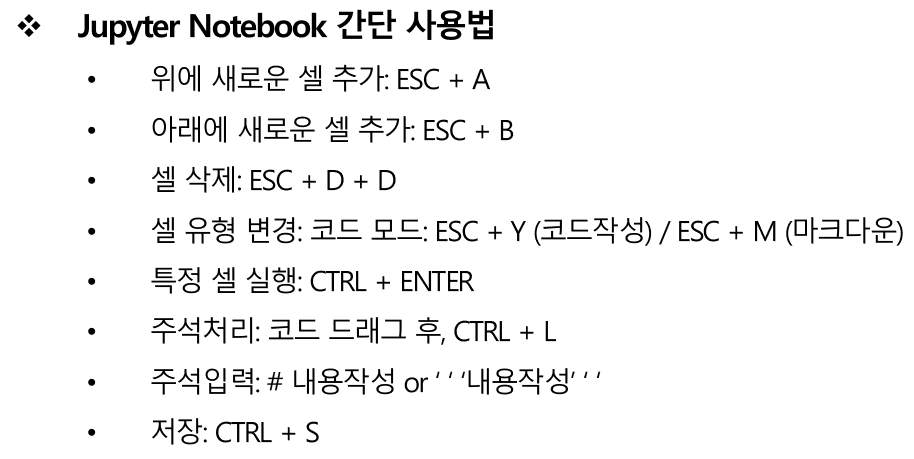

In [ ]:
""" 설명 장표 불러오기 """
from IPython.display import Image
# Image('image/image2.PNG') ### 로컬 사용시
Image('/content/2025-LGElec-Day11/image/image2.PNG') ### colab 사용시

## **3. 강의목차**
 - Tutorial1. CNN 기본

 - **Tutorial2. CNN을 활용한 이미지 모델링**

 - Tutorial3. CNN을 활용한 이미지 모델링 (Advanced)

 - Tutorial4. CNN을 활용한 시계열 모델링

## **Tutorial2 실습: CNN 이미지 모델링**

 -  딥러닝 이미지 모델링 튜토리얼

 -  다양한 모델 구조 실험

 -  전체 학습 VS 일부 학습 (사전학습 모델의 효과)

## **0. 필요 패키지 불러오기**

In [ ]:
""" 전처리 관련 패키지 """
import os
import random
import numpy as np
from PIL import Image as Img

""" 딥러닝 모델링 패키지 """
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from sklearn.metrics import accuracy_score, f1_score

""" 데이터 시각화 패키지 """
import matplotlib.pyplot as plt


""" 경고 숨기기 """
import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
""" GPU 설정 및 랜덤성 제어 """

### GPU 설정
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### 각 패키지 별 랜덤성 제어
random.seed(777)
np.random.seed(777)
torch.manual_seed(777)
if device =='cuda':
    torch.cuda.manual_seed(777)
    torch.cuda.manual_seed_all(777)

## **1. 딥러닝 이미지 모델링 튜토리얼**
 - 분석데이터: Ants & Bees Classification

 - Ants → Train : Valid : Test = 120 : 40 : 33

 - Bees → Train : Valid : Test = 120 : 40 : 44

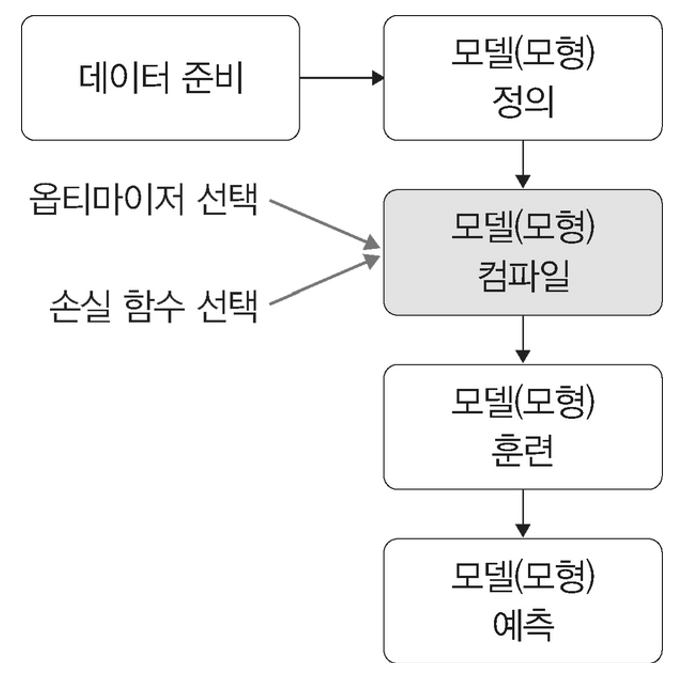

In [ ]:
""" 설명 장표 불러오기 """
# Image('image/image15.PNG') ### 로컬 사용시
Image('/content/2025-LGElec-Day11/image/image15.PNG') ### colab 사용시

#### **1-1. 데이터 준비**

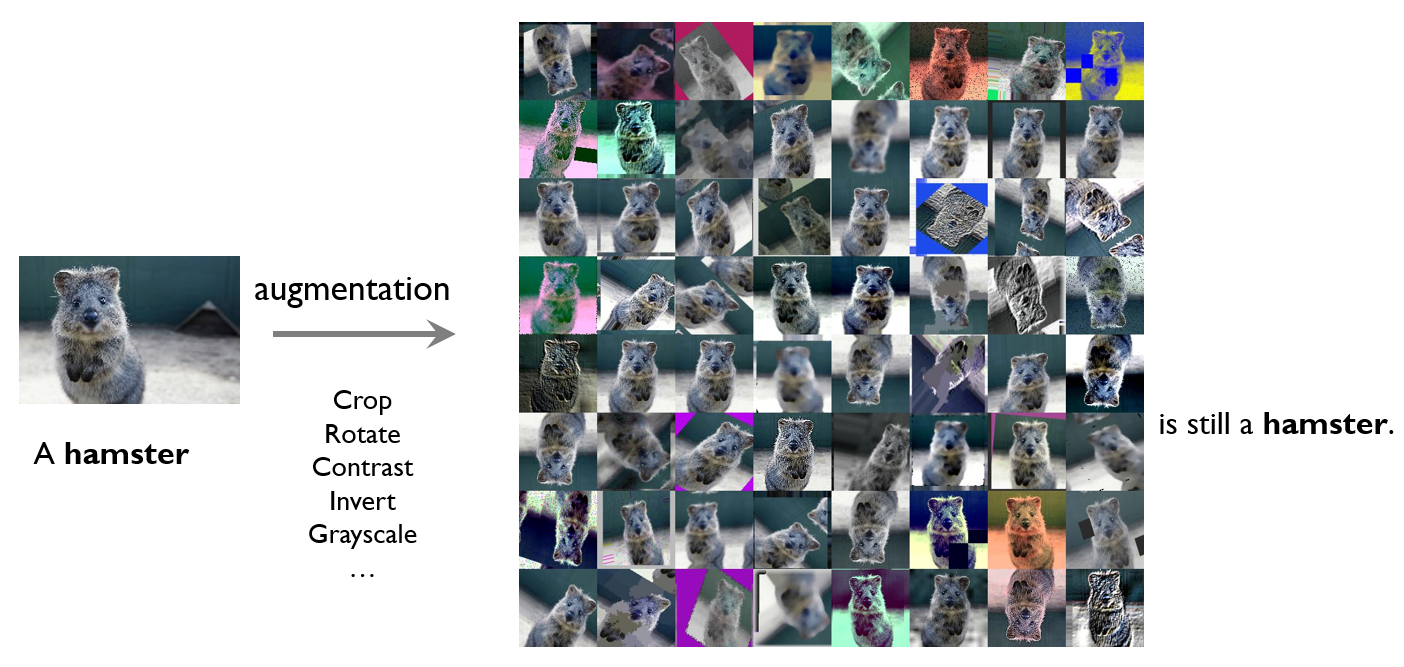

In [ ]:
""" 설명 장표 불러오기 """
# Image('image/image16.PNG') ### 로컬 사용시
Image('/content/2025-LGElec-Day11/image/image16.PNG') ### colab 사용시

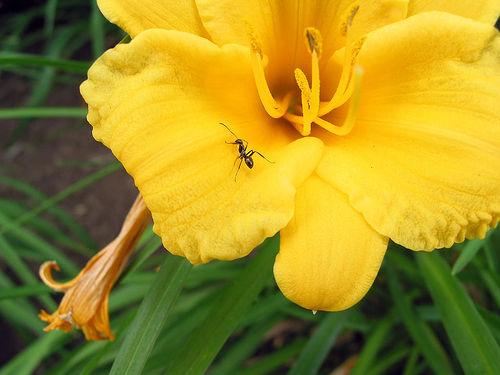

In [ ]:
""" 이미지 데이터 증강을 위한 이미지 불러오기 """
# img = Img.open('data/ant_bee/train/ants/24335309_c5ea483bb8.jpg') ### 로컬 사용시
img = Img.open('/content/2025-LGElec-Day11/data/ant_bee/train/ants/24335309_c5ea483bb8.jpg') ### colab 사용시
img

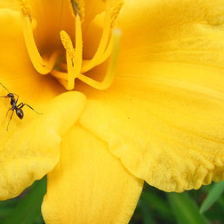

In [ ]:
""" 이미지 데이터 증강 (1) """
transforms.RandomResizedCrop(size=224, scale=(0.3, 0.8))(img)

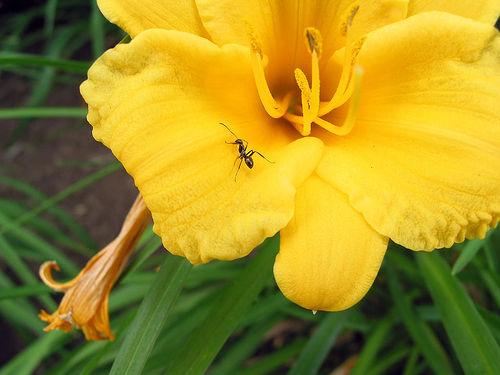

In [ ]:
""" 이미지 데이터 증강 (2) """
transforms.RandomHorizontalFlip(p=0.5)(img)

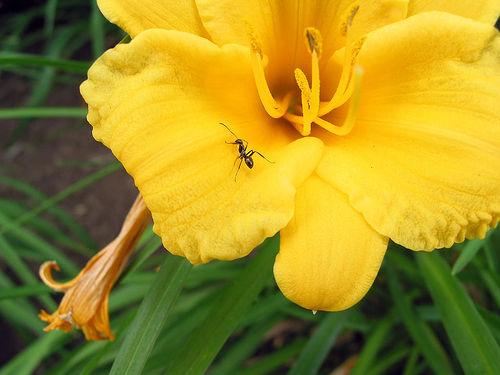

In [ ]:
""" 이미지 데이터 증강 (3) """
transforms.RandomVerticalFlip(p=0.5)(img)

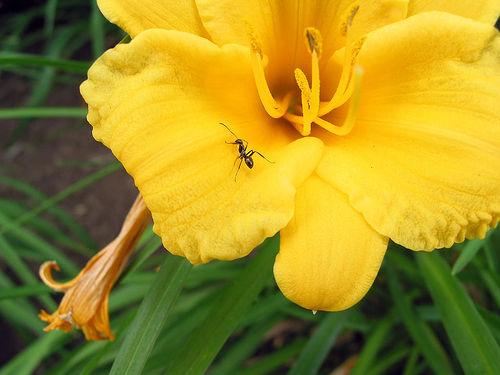

In [ ]:
""" 이미지 데이터 증강 (4) """
transforms.RandomGrayscale(p=0.5)(img)

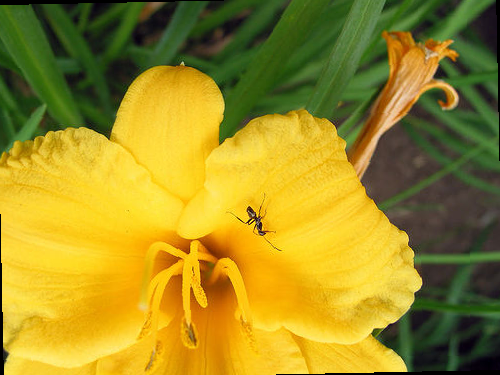

In [ ]:
""" 이미지 데이터 증강 (5) """
transforms.RandomRotation(degrees=(0, 360))(img)

In [ ]:
""" 데이터 증강 설정 """
### train 데이터를 위한 증강 기법
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.5, 1)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomGrayscale(p=0.5),
    transforms.RandomRotation(degrees=(0, 360)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ### 이미지 정규화 ([R_mean, G_mean, B_mean], [R_std, G_std, B_std])
])
### valid 및 test 데이터를 위한 증강 기법
val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_transforms = {'train':train_transform, 'val':val_transform, 'test':val_transform}

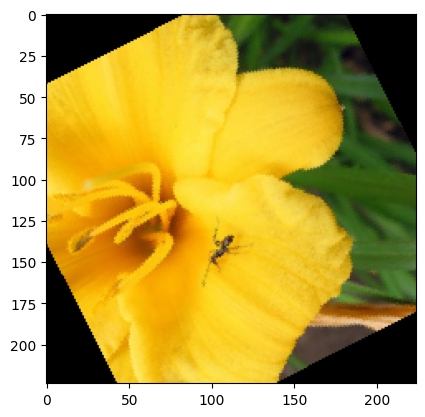

In [ ]:
""" 데이터 증강 예시 확인 """
### 데이터 증강 적용
img1 = data_transforms['train'](img)

### 정규화 해제
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img1 = img1.permute(1, 2, 0) * std + mean ### tensor: [C, H, W] --> numpy [H, W, C]
plt.imshow(img1)

In [ ]:
""" 데이터셋 정의 """
### 데이터 경로 정의
# data_dir = "data/ant_bee" ### 로컬 사용 시
data_dir = "/content/2025-LGElec-Day11/data/ant_bee" ### colab 사용 시

### 데이터셋(저장소) 정의
train_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'train'),
                                     transform=data_transforms['train'])
val_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'val'),
                                   transform=data_transforms['val'])
test_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'test'),
                                    transform=data_transforms['val'])

train_dataset

Dataset ImageFolder
    Number of datapoints: 240
    Root location: /content/2025-LGElec-Day11/data/ant_bee/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.5, 1), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               RandomGrayscale(p=0.5)
               RandomRotation(degrees=[0.0, 360.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [ ]:
""" Class 이름 정의 """
### class_names 정의
class_names = train_dataset.classes
class_names

['ants', 'bees']

In [ ]:
""" 데이터 로더 정의 """
### 데이터 로더 정의
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=4,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                         batch_size=4,
                                         shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=4,
                                          shuffle=False)

### 데이터 로더 정리
dataloaders = {'train': train_loader,
               'val': val_loader,
               'test': test_loader}

### 데이터셋 사이즈 정의
dataset_sizes = {'train': len(train_dataset),
                 'val': len(val_dataset),
                 'test':len(test_dataset)}

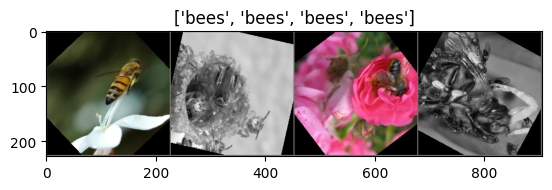

In [ ]:
""" 데이터 로더 검증 """
### 시각화 함수 정의
def imshow(inp, title=None):
    ### 이미지 numpy로 변환
    inp = inp.numpy().transpose((1, 2, 0)) # (channel, height, width) -> (height, width, channel)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    ### 역정규화: 정규화 해제
    inp = std * inp + mean

    ### 이미지 시각화
    plt.imshow(inp)
    if title is not None:
        plt.title(title)


### 시각화
inputs, classes = next(iter(dataloaders['train'])) ### inputs: (batch size, channel, height, width)
out = torchvision.utils.make_grid(tensor=inputs, nrow=4) ### 시각화 그리드 생성
imshow(out, title=[class_names[x] for x in classes])

#### **1-2. 모델 정의**

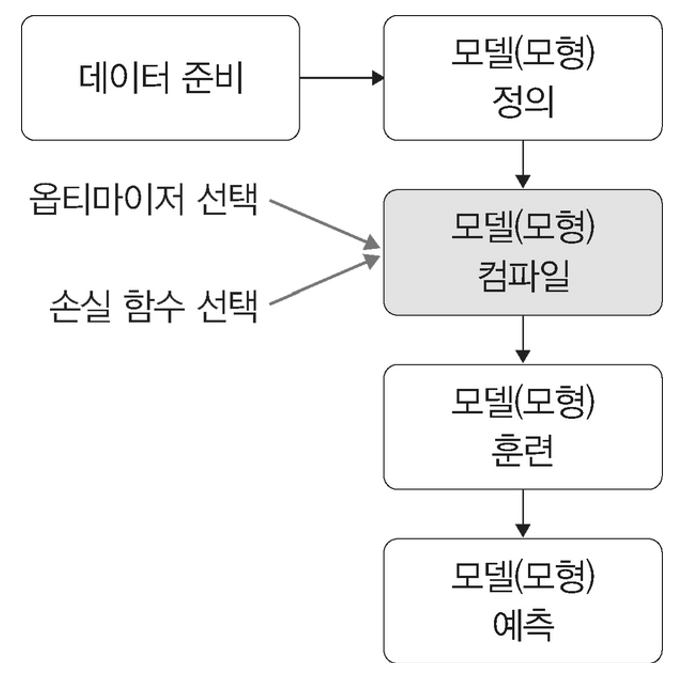

In [ ]:
""" 설명 장표 불러오기 """
# Image('image/image15.PNG') ### 로컬 사용시
Image('/content/2025-LGElec-Day11/image/image15.PNG') ### colab 사용시

In [ ]:
""" 모델 정의 """
alexnet = models.alexnet(pretrained=True) ### 사전학습된 모델 활용

### 마지막 Layer만 내 Task에 맞게 변형
num_in = alexnet.classifier[-1].in_features
alexnet.classifier[-1] = nn.Linear(num_in, 2)

### GPU 할당
alexnet.to(device)

alexnet

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 178MB/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

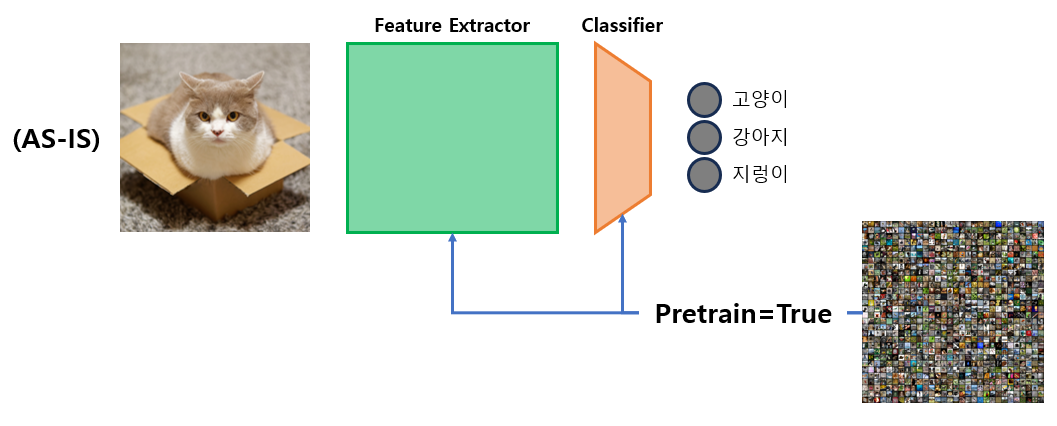

In [ ]:
""" 설명 장표 불러오기 """
# Image('image/image99.PNG') ### 로컬 사용시
Image('/content/2025-LGElec-Day11/image/image99.PNG') ### colab 사용시

#### **1-3. 모델 컴파일**

In [ ]:
""" 모델 컴파일 """
### 옵티마이저
optimizer = optim.SGD(alexnet.parameters(),
                      lr=0.001,
                      momentum=0.9)

### 손실함수
criterion = nn.CrossEntropyLoss()

#### **1-4. 모델 훈련**

In [ ]:
""" 모델 training loop """

### Epoch 단위 구분
best_acc = 0.0
num_epochs = 10
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    print('-' * 10)

    ### Train or Validation 구분
    for phase in ['train', 'val']:
        if phase == 'train':
            alexnet.train() ### Backward 수행O
        else:
            alexnet.eval()  ### Backward 수행X

        ### Iteration 단위 구분
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad() ### 축적된 Gradient 초기화

            with torch.set_grad_enabled(phase == 'train'): ### 모델 예측 및 손실함수값 산출
                outputs = alexnet(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward() ### Backpropagation
                    optimizer.step()

            ### Log
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects / dataset_sizes[phase]

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

        ### Save Best Model
        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            content = {
                'epoch': epoch,
                'acc': epoch_acc,
                'model': alexnet.state_dict()
            }
            try:
              torch.save(content, 'checkpoint/alex_best.pt') ### 로컬 경로
            except:
              torch.save(content, '/content/2025-LGElec-Day11/checkpoint/alex_best.pt') ### colab 경로

print('Best val Acc: {:4f}'.format(best_acc))

Epoch 1/10
----------
train Loss: 1.0503 Acc: 0.6167
val Loss: 0.7646 Acc: 0.4875
Epoch 2/10
----------
train Loss: 0.7364 Acc: 0.5333
val Loss: 0.6544 Acc: 0.6750
Epoch 3/10
----------
train Loss: 0.6934 Acc: 0.5750
val Loss: 0.6940 Acc: 0.5000
Epoch 4/10
----------
train Loss: 0.6848 Acc: 0.5750
val Loss: 0.6904 Acc: 0.5750
Epoch 5/10
----------
train Loss: 0.6660 Acc: 0.5625
val Loss: 0.6368 Acc: 0.6750
Epoch 6/10
----------
train Loss: 0.6655 Acc: 0.5792
val Loss: 0.6497 Acc: 0.6625
Epoch 7/10
----------
train Loss: 0.6576 Acc: 0.6083
val Loss: 0.6126 Acc: 0.7000
Epoch 8/10
----------
train Loss: 0.6846 Acc: 0.5708
val Loss: 0.6513 Acc: 0.6500
Epoch 9/10
----------
train Loss: 0.6596 Acc: 0.6000
val Loss: 0.6729 Acc: 0.7375
Epoch 10/10
----------
train Loss: 0.6259 Acc: 0.6458
val Loss: 0.5972 Acc: 0.7000
Best val Acc: 0.737500


#### **1-5. 모델 평가 (예측)**

In [ ]:
""" Best 모델 불러오기 """
# ckpt = torch.load('checkpoint/alex_best.pt') ### 로컬 사용시
ckpt = torch.load('/content/2025-LGElec-Day11/checkpoint/alex_best.pt') ### colab 사용시
alexnet.load_state_dict(ckpt['model'])

<All keys matched successfully>

In [ ]:
""" 모델 성능 평가 """
pred_list = []
true_list = []

### 모델 평가
alexnet.eval()
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        ### 예측값 산출
        y_logit = alexnet(inputs)
        y_pred = torch.argmax(y_logit, dim=1)
        pred_list.extend(y_pred.cpu().numpy())
        true_list.extend(labels.cpu().numpy())

### 평가지표 계산
test_acc = accuracy_score(true_list, pred_list)
test_f1 = f1_score(true_list, pred_list, average='macro')

print('Test Accuracy: {:.3f}'.format(test_acc))
print('Test F1 Score: {:.3f}'.format(test_f1))

Test Accuracy: 0.571
Test F1 Score: 0.564


In [ ]:
""" 이미지 시각화 """
def visualize_model(model, num_images=6):
    model.eval()
    images_so_far = 0
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    ### Inference
    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            ### 시각화
            for j in range(inputs.size()[0]):
                images_so_far += 1
                plt.subplot(num_images//2, 2, images_so_far)
                plt.axis('off')
                plt.title('real: {} | predicted: {}'.format(class_names[labels[j]],
                                                            class_names[preds[j]]))
                img = inputs.cpu().data[j].permute(1, 2, 0) * std + mean
                img = np.clip(img, 0, 1)
                plt.imshow(img)

                ### 종료조건
                if images_so_far == num_images:
                    return

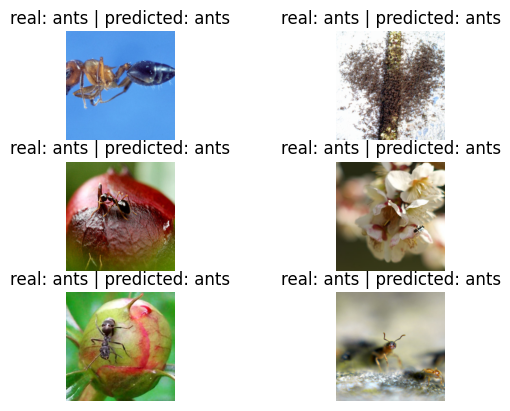

In [ ]:
""" 시각화를 통한 검증 """
visualize_model(alexnet)

## **2. 다양한 모델 구조 실험**

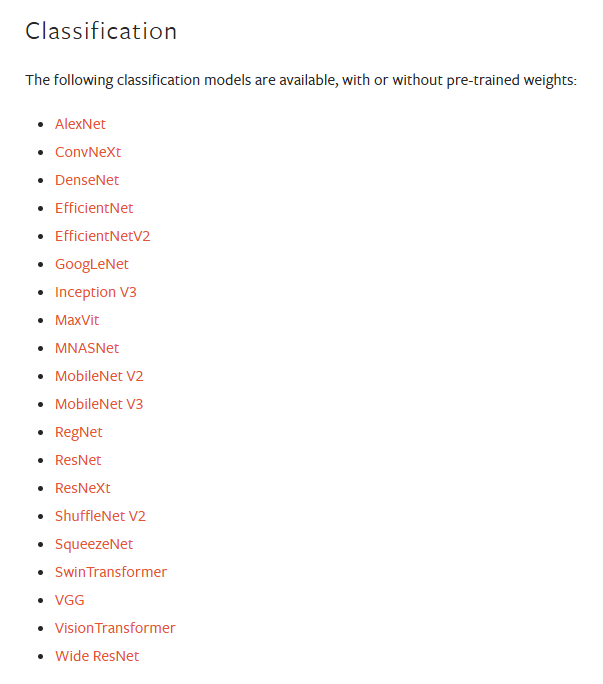

In [ ]:
""" 설명 장표 불러오기 """
# Image('image/image17.PNG') ### 로컬 사용시
Image('/content/2025-LGElec-Day11/image/image17.PNG') ### colab 사용시

In [ ]:
""" 모델 정의 """
vgg16 = models.vgg16(pretrained=True) ### 사전학습된 모델 활용

### 마지막 Layer만 내 Task에 맞게 변형
num_in = vgg16.classifier[-1].in_features
vgg16.classifier[-1] = nn.Linear(num_in, 2)

### GPU 할당
vgg16.to(device)

vgg16

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 101MB/s] 


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
""" 모델 컴파일 """
### 옵티마이저
optimizer = optim.SGD(vgg16.parameters(),
                      lr=0.001,
                      momentum=0.9)

### 손실함수
criterion = nn.CrossEntropyLoss()

In [ ]:
""" 모델 training loop """

### Epoch 단위 구분
best_acc = 0.0
num_epochs = 10
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    print('-' * 10)

    ### Train or Validation 구분
    for phase in ['train', 'val']:
        if phase == 'train':
            vgg16.train() ### Backward 수행O
        else:
            vgg16.eval()  ### Backward 수행X

        ### Iteration 단위 구분
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad() ### 축적된 Gradient 초기화

            with torch.set_grad_enabled(phase == 'train'): ### 모델 예측 및 손실함수값 산출
                outputs = vgg16(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward() ### Backpropagation
                    optimizer.step()

            ### Log
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects / dataset_sizes[phase]

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

        ### Save Best Model
        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            content = {
                'epoch': epoch,
                'acc': epoch_acc,
                'model': vgg16.state_dict()
            }
            try:
              torch.save(content, 'checkpoint/vgg16_best.pt') ### 로컬 경로
            except:
              torch.save(content, '/content/2025-LGElec-Day11/checkpoint/vgg16_best.pt') ### colab 경로

print('Best val Acc: {:4f}'.format(best_acc))

Epoch 1/10
----------
train Loss: 0.5980 Acc: 0.7000
val Loss: 0.9928 Acc: 0.5500
Epoch 2/10
----------
train Loss: 0.6181 Acc: 0.6625
val Loss: 0.6009 Acc: 0.6250
Epoch 3/10
----------
train Loss: 0.4005 Acc: 0.8083
val Loss: 0.2513 Acc: 0.8875
Epoch 4/10
----------
train Loss: 0.4285 Acc: 0.7917
val Loss: 0.2556 Acc: 0.9000
Epoch 5/10
----------
train Loss: 0.4459 Acc: 0.8333
val Loss: 0.3141 Acc: 0.9125
Epoch 6/10
----------
train Loss: 0.3436 Acc: 0.8583
val Loss: 0.2600 Acc: 0.9000
Epoch 7/10
----------
train Loss: 0.3356 Acc: 0.8583
val Loss: 0.2359 Acc: 0.9000
Epoch 8/10
----------
train Loss: 0.3625 Acc: 0.8292
val Loss: 0.3114 Acc: 0.8500
Epoch 9/10
----------
train Loss: 0.3058 Acc: 0.8375
val Loss: 0.3130 Acc: 0.8875
Epoch 10/10
----------
train Loss: 0.2252 Acc: 0.9125
val Loss: 0.5033 Acc: 0.8250
Best val Acc: 0.912500


In [ ]:
""" Best 모델 불러오기 """
# ckpt = torch.load('checkpoint/vgg16_best.pt') ### 로컬 사용시
ckpt = torch.load('/content/2025-LGElec-Day11/checkpoint/vgg16_best.pt') ### colab 사용시
vgg16.load_state_dict(ckpt['model'])

<All keys matched successfully>

In [ ]:
""" 모델 성능 평가 """
pred_list = []
true_list = []

### 모델 평가
alexnet.eval()
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        ### 예측값 산출
        y_logit = vgg16(inputs)
        y_pred = torch.argmax(y_logit, dim=1)
        pred_list.extend(y_pred.cpu().numpy())
        true_list.extend(labels.cpu().numpy())

### 평가지표 계산
test_acc = accuracy_score(true_list, pred_list)
test_f1 = f1_score(true_list, pred_list, average='macro')

print('Test Accuracy: {:.3f}'.format(test_acc))
print('Test F1 Score: {:.3f}'.format(test_f1))

Test Accuracy: 0.883
Test F1 Score: 0.882


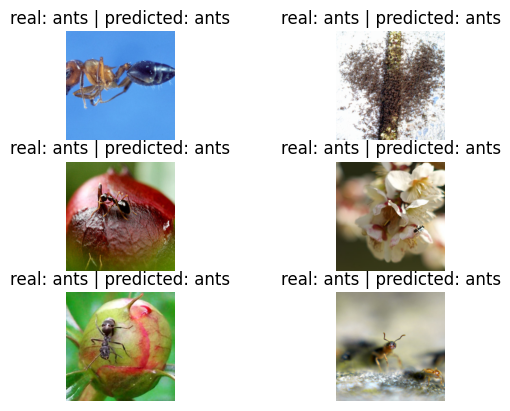

In [ ]:
""" 시각화를 통한 검증 """
visualize_model(vgg16)

## **3. 전체 학습 VS 일부 학습 (사전학습 모델의 효과)**

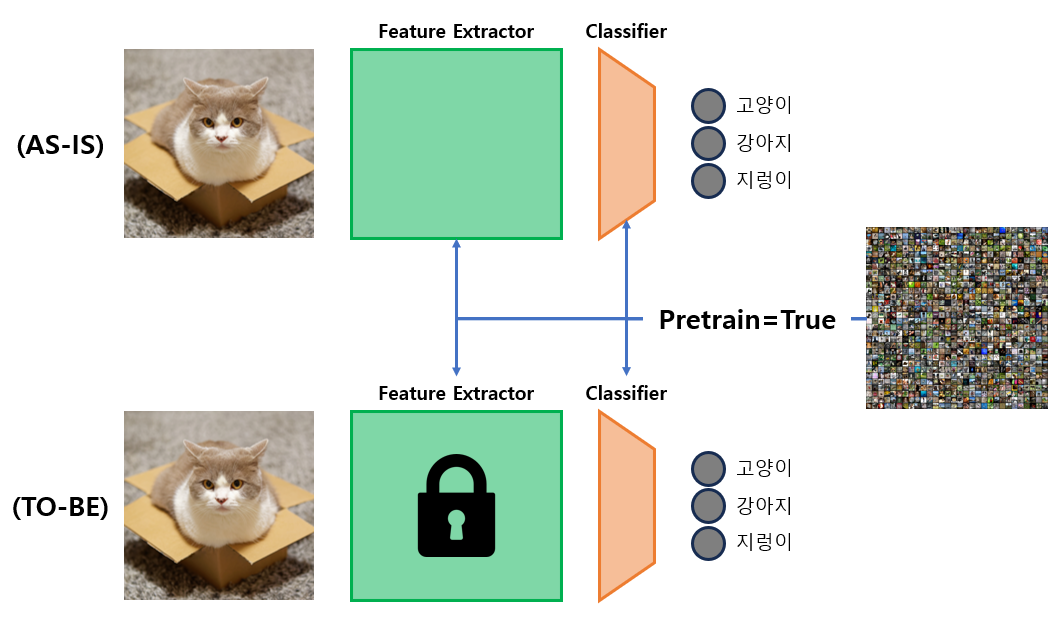

In [ ]:
""" 설명 장표 불러오기 """
# Image('image/image18.PNG') ### 로컬 사용시
Image('/content/2025-LGElec-Day11/image/image18.PNG') ### colab 사용시

In [ ]:
""" 모델 정의 """
vgg16_ft = models.vgg16(pretrained=True) ### 사전학습된 모델 활용

In [ ]:
""" 파라미터 gradient 전파 해제"""
for param in vgg16_ft.parameters():
    param.requires_grad = False

In [ ]:
""" 마지막 Layer만 내 Task에 맞게 변형 """
num_in = vgg16_ft.classifier[-1].in_features
vgg16_ft.classifier[-1] = nn.Linear(num_in, 2) ### 새롭게 추가된 Layer는 requires_grad=True가 Default

### GPU 할당
vgg16_ft.to(device)

vgg16_ft

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
""" Gradient 검토 (1) """
for param in vgg16_ft.features.parameters():
    print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


In [ ]:
""" Gradient 검토 (2) """
for param in vgg16_ft.classifier.parameters():
    print(param.requires_grad)

False
False
False
False
True
True


In [ ]:
""" 모델 컴파일 """
### 옵티마이저
optimizer = optim.SGD(vgg16_ft.parameters(),
                      lr=0.001,
                      momentum=0.9)

### 손실함수
criterion = nn.CrossEntropyLoss()

In [ ]:
""" 모델 training loop """

### Epoch 단위 구분
best_acc = 0.0
num_epochs = 10
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    print('-' * 10)

    ### Train or Validation 구분
    for phase in ['train', 'val']:
        if phase == 'train':
            vgg16_ft.train() ### Backward 수행O
        else:
            vgg16_ft.eval()  ### Backward 수행X

        ### Iteration 단위 구분
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad() ### 축적된 Gradient 초기화

            with torch.set_grad_enabled(phase == 'train'): ### 모델 예측 및 손실함수값 산출
                outputs = vgg16_ft(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward() ### Backpropagation
                    optimizer.step()

            ### Log
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects / dataset_sizes[phase]

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

        ### Save Best Model
        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            content = {
                'epoch': epoch,
                'acc': epoch_acc,
                'model': vgg16_ft.state_dict()
            }
            try:
              torch.save(content, 'checkpoint/vgg16_ft_best.pt') ### 로컬 경로
            except:
              torch.save(content, '/content/2025-LGElec-Day11/checkpoint/vgg16_ft_best.pt') ### colab 경로

print('Best val Acc: {:4f}'.format(best_acc))

Epoch 1/10
----------
train Loss: 0.6279 Acc: 0.7667
val Loss: 0.1526 Acc: 0.9500
Epoch 2/10
----------
train Loss: 0.6549 Acc: 0.8042
val Loss: 0.1317 Acc: 0.9750
Epoch 3/10
----------
train Loss: 0.6736 Acc: 0.8333
val Loss: 0.1707 Acc: 0.9750
Epoch 4/10
----------
train Loss: 0.5455 Acc: 0.8375
val Loss: 0.0860 Acc: 0.9750
Epoch 5/10
----------
train Loss: 0.5527 Acc: 0.8542
val Loss: 0.1075 Acc: 0.9750
Epoch 6/10
----------
train Loss: 0.6530 Acc: 0.8917
val Loss: 0.0433 Acc: 0.9875
Epoch 7/10
----------
train Loss: 0.5610 Acc: 0.8958
val Loss: 0.0301 Acc: 0.9750
Epoch 8/10
----------
train Loss: 0.3670 Acc: 0.9000
val Loss: 0.1026 Acc: 0.9750
Epoch 9/10
----------
train Loss: 0.5861 Acc: 0.8792
val Loss: 0.0756 Acc: 0.9875
Epoch 10/10
----------
train Loss: 0.5798 Acc: 0.8583
val Loss: 0.1413 Acc: 0.9750
Best val Acc: 0.987500


In [ ]:
""" Best 모델 불러오기 """
# ckpt = torch.load('checkpoint/vgg16_ft_best.pt') ### 로컬 사용시
ckpt = torch.load('/content/2025-LGElec-Day11/checkpoint/vgg16_ft_best.pt') ### colab 사용시
vgg16_ft.load_state_dict(ckpt['model'])

<All keys matched successfully>

In [ ]:
""" 모델 성능 평가 """
pred_list = []
true_list = []

### 모델 평가
alexnet.eval()
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        ### 예측값 산출
        y_logit = vgg16_ft(inputs)
        y_pred = torch.argmax(y_logit, dim=1)
        pred_list.extend(y_pred.cpu().numpy())
        true_list.extend(labels.cpu().numpy())

### 평가지표 계산
test_acc = accuracy_score(true_list, pred_list)
test_f1 = f1_score(true_list, pred_list, average='macro')

print('Test Accuracy: {:.3f}'.format(test_acc))
print('Test F1 Score: {:.3f}'.format(test_f1))

Test Accuracy: 0.961
Test F1 Score: 0.960


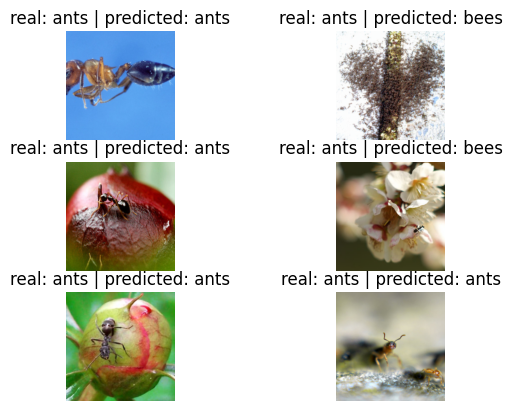

In [ ]:
""" 시각화를 통한 검증 """
visualize_model(vgg16_ft)

# **EOD**